In [6]:
import numpy as np
import pandas as pd
from scipy.special import factorial,multigammaln
from numpy.testing import assert_almost_equal
from functools import partial

from sklearn import cluster
from sklearn.preprocessing import normalize
import time
import matplotlib.pyplot as plt

from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

import multiprocessing as mp
from multiprocessing import Pool, Value, Array

%load_ext cython

## Hiearchichal Aggloremative Clustering using Euclidian Distance as a linkage Metric

In [7]:
## Load the sample data from UCI on the element composition and type of glass for testing

columns=["Refractive_Index" , "Sodium" ,"Magnesium","Aluminum","Silicon","Potassium","Calcium","Barium","Iron","Type of glass"]
df=pd.read_csv("Data_glass.csv",header=None,names=columns)
X=np.array(df.iloc[:, :-1])
y=np.array(df.iloc[:, -1])

In [42]:
## Data set on Brain Waves

columns=["Sex", "Age_range", "Head_size", "Brain_weight"]
df_brain=pd.read_csv("Brain_Weight.csv", sep = "    " , header=None,names=columns)

df_brain['Category'] = 0
df_brain.loc[(df_brain.Sex == 0) & (df_brain.Age_range == 0), "Category"] = 0
df_brain.loc[(df_brain.Sex == 0) & (df_brain.Age_range == 1), "Category"] = 1
df_brain.loc[(df_brain.Sex == 1) & (df_brain.Age_range == 0), "Category"] = 2
df_brain.loc[(df_brain.Sex == 1) & (df_brain.Age_range == 1), "Category"] = 3
cols = df_brain.columns.tolist()
df1 = df_brain[['Category', 'Head_size','Brain_weight']]
df1
X1=np.array(df1.iloc[:, 1:])
Y1=np.array(df1.iloc[:, 0])


## Standardize
X1=normalize(X1)
X1=(X1-X1.mean(axis=0))/X1.std(axis=0)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


237

In [9]:
X=(X-X.mean(axis=0))/X.std(axis=0)

In [10]:
## Synthetic Gaussian Data with mean=0 and variance =1
mean=np.zeros(2)
var=np.eye(2)
synthetic=np.random.multivariate_normal(mean,var,size=50)

In [11]:
def plot(X,k,typ="agg"):
    if typ=="kmean":
        clust=cluster.KMeans(n_clusters=k) 
    else:
        clust=cluster.AgglomerativeClustering(n_clusters=k)
    y_hat=clust.fit_predict(X)
    plt.scatter(X[:,0],X[:,1],c=y_hat)
    pass
    

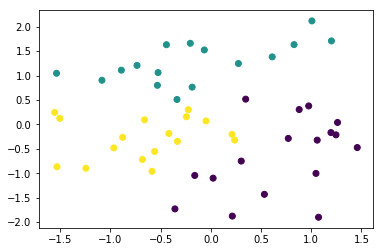

In [12]:
plot(synthetic,3,typ="agg")

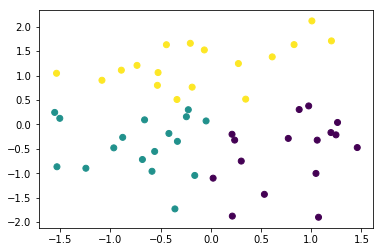

In [13]:
plot(synthetic,3,typ="kmean")

In [14]:
## Calculation with real data
clust=cluster.AgglomerativeClustering(n_clusters=2)

In [15]:
%%time 
y_hat=clust.fit_predict(synthetic)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.37 ms


In [16]:
clust=cluster.AgglomerativeClustering(n_clusters=7)

In [17]:
%%time 
y_hat=clust.fit_predict(X)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.94 ms


## K-Means using Euclidian Distance as a linkage Metric

In [18]:
clust2=cluster.KMeans(n_clusters=2)

In [19]:
%%time 

y_hat2=clust2.fit_predict(synthetic)

CPU times: user 24 ms, sys: 4 ms, total: 28 ms
Wall time: 27 ms


In [20]:
clust2=cluster.KMeans(n_clusters=7)

In [21]:
%%time 

y_hat2=clust2.fit_predict(X)

CPU times: user 56 ms, sys: 8 ms, total: 64 ms
Wall time: 61 ms


In [22]:
X=synthetic
eta0=np.cov(X, rowvar=False)
kappa0=len(X)/20
v0=kappa0*2
#μ0=X.mean(axis=0)
mu0=X.mean(axis=0)


## Working on the Bayesian Clustering

## Initial Algorithm /Using a new class Node 

In [23]:
## Define a new class called note which has the data points d_k and the number of the cluster

class Node:
    from scipy.special import factorial

    
    def __init__(self,p,alpha,i):
        
        self.single=True
        self.points=set()
        self.points.add(p)
        self.d=alpha
        self.number=i
        self.left=None
        self.right=None
        self.ph=0
            
    def add(self,x):
        self.points.add(x)
        
    def add_all(self,x):
        self.points=x
        
    def remove(self,x):
        self.points.remove(x)
        
    def combine(self,y,alpha):
        p=self.points.union(y.points)
        z=Node(1,self.d,self.number)
        z.left=self
        z.right=y
        z.remove(1)
        z.points=p
        z.d= alpha*factorial(len(p)-1)+self.d*y.d
        z.single=False
        return z 
        
        

$$ p(D_k|H_1^k)=\frac{1}{\pi^{nd/2}} \frac{\Gamma_d(v_n/2)}{\Gamma_d(v_0/2)} \frac{|\Lambda_0|^{v_0/2}}{|\Lambda_n|^{v_n/2}} (\frac{\kappa_0}{\kappa_n})^{d/2}  $$

where: 

$$ \kappa_n= \kappa_0 +n  , v_n = v_0 +n$$

initialize $$ \kappa_0 , v_0 ,\mu_0 , \Lambda_0$$



$$  p(D_k|T_k) = \pi_k p(D_k|H_1^k)+(1-\pi_k)p(D_i|T_i)p(D_j|T_j) $$



In [24]:
def prob_hypo(X,kappa0,v0,mu0,eta0):
    from decimal import Decimal
    nf,df= X.shape
    n=Decimal(nf)
    d=Decimal(df)
    a= (1/(Decimal(np.pi))**(n*d/2))
    b=Decimal(multigammaln((v0+nf)/2,df)/multigammaln(v0/2,df))
    S=np.zeros((df,df))
    for i in range(nf):
        o=X[i]-X.mean(axis=0)
        S+=np.outer(o,o)
    etan=(eta0) + S + (kappa0*nf/(kappa0+nf))*np.outer((X.mean(axis=0)-mu0),(X.mean(axis=0)-mu0))
    c=Decimal(np.linalg.det(eta0)**(v0/2))/(Decimal(np.linalg.det(etan))**((Decimal(v0)+n)/2))
    d=Decimal(kappa0/(kappa0+nf))**(d/2)
    return float(a*b*c*d)
    
    

In [25]:
## Function that initiates clusters
def init(X,alpha,kappa0,v0,mu0,eta0):
    x=[]
    for i in range(len(X)):
        node=Node(i,alpha,i)
        node.ph=prob_hypo(X[[i]],kappa0,v0,mu0,eta0)
        x.append(node)
        
    return x

In [26]:
## Function that returns two matrices for each index combination
## param @rik : r values, param @pit, pi values
def calculate_r(nodes,alpha,X,kappa0,v0,mu0,eta0):
    from scipy.special import factorial
    n=len(nodes)
    rik=np.zeros((n,n))
    pit=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            clust_k=nodes[i].combine(nodes[j],alpha)
            nk=len(clust_k.points)
            dk=clust_k.d
            pi=alpha*factorial(nk-1)/dk
            all_points=list(clust_k.points)
            ph=prob_hypo(X[all_points][:],kappa0,v0,mu0,eta0) 
            pt=ph*pi+ (1-pi)*nodes[i].ph*nodes[j].ph
            pit[i,j]=pt
            rik[i,j]=(pi*ph)/pt
           
    np.fill_diagonal(rik,-10)
    return rik,pit

In [27]:
## Function for updating clusters, by creating a new node (combination of i and j) and deleting nodes i,j
def update_clust(rk,pit,nodes,alpha):
    i,j=np.unravel_index(np.argmax(rk),rk.shape)
    if len(nodes[i].points)>len(nodes[j].points):
        new_node=nodes[i].combine(nodes[j],alpha)
    else:
        new_node=nodes[j].combine(nodes[i],alpha)
    new_node.single=False
    new_node.ph=pit[i,j]
    nodes[i]=new_node 
    del nodes[j]
    return nodes

In [28]:
## Bayesian Cluster algorithm which returns the final classes only.
def bayesian_clust(X,alpha,kappa0,v0,mu0,eta0,k=3):
    nodes=init(X,alpha,kappa0,v0,mu0,eta0)
    
    for i in range(len(nodes)-k):
        rk,pit=calculate_r(nodes,alpha,X,kappa0,v0,mu0,eta0)
        nodes=update_clust(rk,pit,nodes,alpha)
    y=np.zeros(len(X))
    for i in range(k):
        ind=list(nodes[i].points)
        y[ind]=i
    for i in range(k-1):
        rk,pit=calculate_r(nodes,alpha,X,kappa0,v0,mu0,eta0)
        nodes=update_clust(rk,pit,nodes,alpha)
        
    return y,nodes[0]

In [738]:
%%time
y1=bayesian_clust(X,3,kappa0,v0,mu0,eta0,k=3)[0]

CPU times: user 26 s, sys: 688 ms, total: 26.7 s
Wall time: 26.4 s


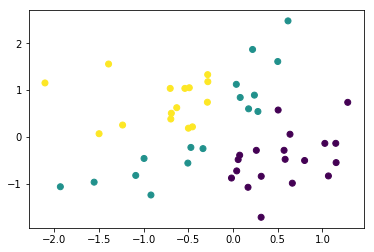

In [739]:
plt.scatter(X[:,0],X[:,1],c=y1)
pass

# Optimizing the code / Reducing the loop size

Looping through only the upper right triangle matrix will decrease the time spend on the loop

In [29]:
## Making the loop faster-- Only loop to fill the upper triangular part of the numpy matrix
def calculate_r_fast(nodes,alpha,X,kappa0,v0,mu0,eta0):
    from scipy.special import factorial
    n=len(nodes)
    rik=np.zeros((n,n))
    pit=np.zeros((n,n))
    for i in range(n):
        for j in range(i+1,n):
            clust_k=nodes[i].combine(nodes[j],alpha)
            nk=len(clust_k.points)
            dk=clust_k.d
            pi=alpha*factorial(nk-1)/dk
            all_points=list(clust_k.points)
            ph=prob_hypo(X[all_points][:],kappa0,v0,mu0,eta0) 
            pt=ph*pi+ (1-pi)*nodes[i].ph*nodes[j].ph
            pit[i,j]=pt
            rik[i,j]=(pi*ph)/pt
           
    np.fill_diagonal(rik,-10)
    return rik,pit


In [30]:
## Bayesian Cluster algorithm which returns the final classes only.
def bayesian_clust_fast(X,alpha,kappa0,v0,mu0,eta0,k=3):
    nodes=init(X,alpha,kappa0,v0,mu0,eta0)
   
    for i in range(len(nodes)-k):
        rk,pit=calculate_r_fast(nodes,alpha,X,kappa0, v0,mu0, eta0)
        nodes=update_clust(rk,pit,nodes,alpha)
    y=np.zeros(len(X))
    for i in range(k):
        ind=list(nodes[i].points)
        y[ind]=i
    for i in range(k-1):
        rk,pit=calculate_r_fast(nodes,alpha,X,kappa0,v0,mu0,eta0)
        nodes=update_clust(rk,pit,nodes,alpha)
        
    return y,nodes[0]

In [31]:
X=synthetic
eta0=np.cov(X, rowvar=False)
kappa0=len(X)/20
v0=kappa0*3
#μ0=X.mean(axis=0)
mu0=X.mean(axis=0)


In [746]:
%%time
y2=bayesian_clust_fast(X,3,kappa0,v0,mu0,eta0,k=3)[0]


CPU times: user 13.5 s, sys: 176 ms, total: 13.7 s
Wall time: 13.7 s


In [32]:
plt.scatter(X[:,0],X[:,1],c=y2)
pass

NameError: name 'y2' is not defined

In [34]:
%%time
y1=bayesian_clust(X,3,kappa0,v0,mu0,eta0,k=3)[0]

CPU times: user 5.37 s, sys: 252 ms, total: 5.62 s
Wall time: 5.51 s


In [305]:
%timeit -r3 -n5 bayesian_clust(X,3,kappa0,v0,mu0,eta0,k=3)
%timeit -r3 -n5 bayesian_clust_fast(X,3,kappa0,v0,mu0,eta0,k=3)

5.27 s ± 35 ms per loop (mean ± std. dev. of 3 runs, 5 loops each)
2.46 s ± 23.6 ms per loop (mean ± std. dev. of 3 runs, 5 loops each)


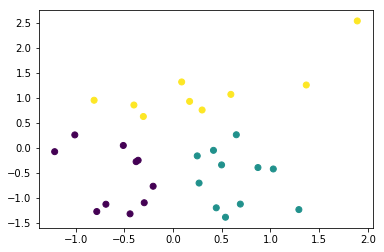

In [35]:
plt.scatter(X[:,0],X[:,1],c=y1)
pass

In [73]:
%%cython -a
import numpy as np
import cython
from scipy.special import multigammaln
from decimal import Decimal
from cython.parallel import parallel, prange

##Recursive function that calculates factorial faster than scipy

@cython.wraparound(False)
@cython.boundscheck(False)
cdef fact(int x):
    if x==0 :
        return 1
    else:
        return x*fact(x-1)
    

class Node_cyt:
  
    def __init__(self,int p,float alpha,int i):
        self.single=True
        self.points=set()
        self.points.add(p)
        self.d=alpha
        self.number=i
        self.left=None
        self.right=None
        self.ph=0
            
    def add(self,int x):
        self.points.add(x)
        
    def add_all(self,int x):
        self.points=x
        
    def remove(self,int x):
        self.points.remove(x)
        
    def combine(self,y,float alpha):
        p=self.points.union(y.points)
        z=Node_cyt(1,self.d,self.number)
        z.left=self
        z.right=y
        z.remove(1)
        z.points=p
        z.d= alpha*fact(len(p)-1)+self.d*y.d
        z.single=False
        return z 

## Function that gives the indeces of maximum value within a Matrix


@cython.wraparound(False)
@cython.boundscheck(False)
cdef get_max(double[:,:] X):
    cdef int n,m,k,l,i,j
    cdef double arg,c
    k=X.shape[0]
    l=X.shape[1]
    arg=0.0
    with cython.nogil:
        for n in range(k):
            for m in range(l):
                c=X[n,m]
                if c>=arg:
                    arg=c
                    i=n
                    j=m
    return i,j

## Function that calculates the mean of a row
@cython.wraparound(False)
@cython.boundscheck(False)
cdef get_mean_1(double[:,:] X,double[:] res):
   
    cdef int i,j,k,m
    cdef double mean
    
    k=X.shape[0]
    m=X.shape[1]
    with cython.nogil ,parallel():
        for j in range(m):
            mean=0
            for i in range(k):
                mean+=X[i,j]
            mean=mean/k
            res[j]=mean
    return np.array(res)

@cython.wraparound(False)
@cython.boundscheck(False)

cdef outer_product(double[:] x, double[:,:] res):
    cdef int n,i,j
    n=x.shape[0]
    with cython.nogil, parallel():
        for i in range(n):
            for j in range(n):
                res[i,j]=x[i]*x[j]
                
@cython.wraparound(False)
@cython.boundscheck(False)
def prob_hypo_cyt( double[:,:] X,double kappa0,double v0, double[:] mu0, double[:,:] eta0):
    cdef int nf, df,i
    nf= X.shape[0]
    df=X.shape[1]
    res=np.zeros((df,df))
    n=Decimal(nf)
    d=Decimal(df)
    a=(1/(Decimal(np.pi))**(n*d/2))
    b=Decimal(multigammaln((v0+nf)/2,df)/multigammaln(v0/2,df))
    S=np.zeros((df,df))
    mean=np.zeros(df)
    mean=get_mean_1(X,mean)
    for i in range(nf):
        o=X[i]-mean
        outer_product(o,res)
        S+=res
    
    outer_product(mean-mu0,res)
    etan=(eta0) + S + (kappa0*nf/(kappa0+nf))*res
    c=Decimal(np.linalg.det(eta0)**(v0/2))/(Decimal(np.linalg.det(etan))**((Decimal(v0)+n)/2))
    d=Decimal(kappa0/(kappa0+nf))**(d/2)
    return float(a*b*c*d)
   

@cython.wraparound(False)
@cython.boundscheck(False)
def init_cyt(X,double alpha, double kappa0,double v0, double[:] mu0, double[:,:] eta0):  
    cdef int i,n
    n=X.shape[0]
    x=[]
    for i in range(n):
        node=Node_cyt(i,alpha,i)
        node.ph=prob_hypo_cyt(X[[i]],kappa0,v0,mu0,eta0)
        x.append(node)
    return x



@cython.wraparound(False)
@cython.boundscheck(False)
def calculate_r_cyt(nodes,double alpha,X,double kappa0,double v0,double[:] mu0, double[:,:] eta0):
    
    cdef int n,i,j,nk
    cdef float dk
    n=len(nodes)
    rik=np.zeros((n,n))-10
    pit=np.zeros((n,n))-10
    for i in range(n):
        for j in range(i+1,n):
            clust_k=nodes[i].combine(nodes[j],alpha)
            nk=len(clust_k.points)
            dk=clust_k.d
            pi=alpha*fact(nk-1)/dk
            all_points=list(clust_k.points)
            ph=prob_hypo_cyt(X[all_points][:],kappa0,v0,mu0,eta0) 
            pt=ph*pi+ (1-pi)*nodes[i].ph*nodes[j].ph
            pit[i,j]=pt
            rik[i,j]=(pi*ph)/pt
           
    
    return rik,pit

@cython.wraparound(False)
@cython.boundscheck(False)
cdef update_clust_cyt(double[:,:] rk,double[:,:] pit,nodes,double alpha):
    cdef int i,j,n,f
    indi=get_max(rk)
    i=indi[0]
    j=indi[1]
    if len(nodes[i].points)>len(nodes[j].points):
        new_node=nodes[i].combine(nodes[j],alpha)
    else:
        new_node=nodes[j].combine(nodes[i],alpha)
    new_node.single=False
    new_node.ph=pit[i,j]
    nodes[i]=new_node 
    del nodes[j]
    return nodes

@cython.wraparound(False)
@cython.boundscheck(False)
def bayesian_clust_cyt(X,double alpha,double kappa0,double v0,mu0,double[:,:] eta0,int k=3):
   
    nodes=init_cyt(X,alpha,kappa0,v0,mu0,eta0)
    cdef int n
    n=X.shape[0]
    rik=np.zeros((n,n))-10
    for i in range(n-k):
        rk,pit=calculate_r_cyt(nodes,alpha,X,kappa0, v0,mu0, eta0)
        nodes=update_clust_cyt(rk,pit,nodes,alpha)
    y=np.zeros(n)
    for i in range(k):
        ind=list(nodes[i].points)
        y[ind]=i
    for i in range(k-1):
        rk,pit=calculate_r_cyt(nodes,alpha,X,kappa0,v0,mu0,eta0)
        nodes=update_clust_cyt(rk,pit,nodes,alpha)
        
    return y,nodes[0]



In [749]:
%timeit -r5 -n10 prob_hypo(X,kappa0,v0,mu0,eta0)
%timeit -r5 -n10 prob_hypo_cyt(X,kappa0,v0,mu0,eta0)


1.82 ms ± 53.8 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
840 µs ± 33.2 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)


In [750]:
alpha=3
## Can see the speed up in calculate_r function using cython
nodes=init(X,3,kappa0,v0,mu0,eta0)
%timeit -r3 -n5 calculate_r_fast(nodes, alpha,X, kappa0, v0,mu0, eta0)
%timeit -r3 -n5 calculate_r_cyt(nodes, alpha,X, kappa0, v0,mu0, eta0)


778 ms ± 20.2 ms per loop (mean ± std. dev. of 3 runs, 5 loops each)
665 ms ± 9.76 ms per loop (mean ± std. dev. of 3 runs, 5 loops each)


In [751]:
%%time
y3=bayesian_clust_cyt(X,3,kappa0,v0,mu0,eta0,k=3)[0]

CPU times: user 10.7 s, sys: 12 ms, total: 10.8 s
Wall time: 10.8 s


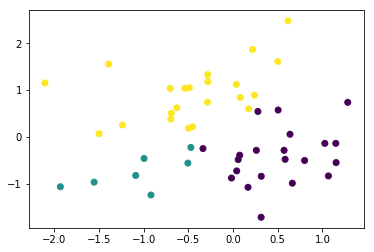

In [752]:
plt.scatter(X[:,0],X[:,1],c=y3)
pass

In [753]:
## They give the same outputs as excepted
assert_almost_equal(bayesian_clust_fast(X,3,kappa0,v0,mu0,eta0,k=3)[0], bayesian_clust_cyt(X,3,kappa0,v0,mu0,eta0,k=3)[0])
assert_almost_equal(bayesian_clust(X,3,kappa0,v0,mu0,eta0,k=3)[0], bayesian_clust_cyt(X,3,kappa0,v0,mu0,eta0,k=3)[0])


In [43]:
%timeit -r3 -n5 bayesian_clust(X,3,kappa0,v0,mu0,eta0,k=3)
%timeit -r3 -n5 bayesian_clust_fast(X,3,kappa0,v0,mu0,eta0,k=3)
%timeit -r3 -n5 bayesian_clust_cyt(X,3,kappa0,v0,mu0,eta0,k=3)


5.49 s ± 55.3 ms per loop (mean ± std. dev. of 3 runs, 5 loops each)
2.62 s ± 26.8 ms per loop (mean ± std. dev. of 3 runs, 5 loops each)
2.05 s ± 13 ms per loop (mean ± std. dev. of 3 runs, 5 loops each)


## Impurity Measure Calculations

In [34]:
## Function that gives all the nodes in a tree recursively
def get_allthenodes(tree,nodes):
    if tree==None:
        pass
    else:
        nodes.append(tree)
        get_allthenodes(tree.left,nodes)
        get_allthenodes(tree.right,nodes)
        
## Simple functions to keep track of points in the sets        
def contains(x,i,j):
    
    if i in x and j in x:
        return True
    else:
        return False
    
## Function that calculate the smallest subtree given the list of all nodes
def find_subtree(i,j,nodes):
    n=float('inf')
    for k in nodes :
        s=k.points
        if contains(s,i,j) and len(s)<n:
            res=k
            n=len(s)
    return res
        


In [35]:
def calc_impurity(tree,yhat,y,n=100):
    impurity=0
    for i in range(n):
        a=np.arange(len(y))
        i=np.random.choice(a)
        clust=y[i]
        a=np.where(y==clust)[0]
        j=np.random.choice(a)
        nodes=[]
        get_allthenodes(tree,nodes)
        smallest=find_subtree(i,j,nodes)
        s=0
        for i in smallest.points:
            if[y[i]]==clust:
                s+=1
        ratio=s/len(smallest.points)
        impurity+=ratio
    impurity=impurity/n
    return impurity
    

In [45]:
## Testing the algorithm on a random subsample from the brainwave data set
a=np.arange(len(X1))
sample=np.random.choice(a,size=50,replace=False)
X_test=X1[sample]
y_test=Y1[sample]

## Set the parameters
eta0=np.cov(X_test, rowvar=False)
kappa0=len(X_test)/20
v0=kappa0*3
#μ0=X.mean(axis=0)
mu0=X_test.mean(axis=0)



In [64]:
%%time
y_hat,tree_test=bayesian_clust_fast(X_test,2,kappa0,v0,mu0,eta0,k=2)

CPU times: user 14.5 s, sys: 288 ms, total: 14.7 s
Wall time: 14.7 s


In [80]:
m.impurity(tree_test,y_hat,y_test,n=1000)

0.6101938178761069